In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [2]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4', '#1200db', '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x0a, 0x01, 0x4a, 1.0), ]

In [4]:
df = pd.read_csv('exposed_by_country.csv')
country_names = list(set(df.country.unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for country in country_names:
	c = []
	for d in range(len(dates)):
		if not country in list(df[(df.date == dates[d])]['country']) or df[(df.date == dates[d]) & (df['country'] == country)]['count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[country] = dates[d]
			v = df[(df.date == dates[d]) & (df['country'] == country)]['count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(country_names))))}/{len(country_names)}: {country}')
	output[country] = c


001/240: Pakistan
002/240: Croatia
003/240: Wallis And Futuna Islands
004/240: Belize
005/240: Gabon
006/240: Sierra Leone
007/240: Hong Kong
008/240: Brazil
009/240: Afghanistan
010/240: Angola
011/240: Hungary
012/240: Macau
013/240: Malta
014/240: Uzbekistan
015/240: Marshall Islands
016/240: Kiribati
017/240: Algeria
018/240: Cambodia
019/240: Gibraltar
020/240: Kuwait
021/240: Guernsey
022/240: France
023/240: Montenegro
024/240: Federated States Of Micronesia
025/240: Nigeria
026/240: Democratic Republic Of The Congo
027/240: Cook Islands
028/240: Sint Maarten
029/240: Lithuania
030/240: South Sudan
031/240: Zimbabwe
032/240: Falkland Islands (Malvinas)
033/240: Lebanon
034/240: Aland Islands
035/240: Peru
036/240: Slovakia (Slovak Republic)
037/240: Chile
038/240: Georgia
039/240: Philippines
040/240: Namibia
041/240: Greece
042/240: Tonga
043/240: Guinea-Bissau
044/240: Cyprus
045/240: Albania
046/240: Chad
047/240: Russian Federation
048/240: Taiwan Province Of China
049/240: 

In [5]:
from json import dumps
jsonified = dumps(output)
with open('./exposed-by-country.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [6]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for country in country_names:
    for c in range(len(output[country])):
        if output[country][c][0] != 0 or output[country][c][1] != 0 or output[country][c][2] != 0 or output[country][c][3] != 0:
            appearance[country] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

country_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [7]:
norm=LogNorm(vmin=1, vmax=50000000)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [8]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(dates))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

001/240: Tokelau
002/240: Christmas Island
003/240: British Indian Ocean Territory
004/240: Montserrat
005/240: Guinea-Bissau
006/240: Falkland Islands (Malvinas)
007/240: Holy See (Vatican City State)
008/240: Eritrea
009/240: Zimbabwe
010/240: Zambia
011/240: Yemen
012/240: Wallis And Futuna Islands
013/240: Viet Nam
014/240: Venezuela
015/240: Vanuatu
016/240: Uzbekistan
017/240: Us Virgin Islands
018/240: Uruguay
019/240: United States
020/240: United Kingdom
021/240: United Arab Emirates
022/240: Ukraine
023/240: Uganda
024/240: Turks And Caicos Islands
025/240: Turkmenistan
026/240: Turkey
027/240: Tunisia
028/240: Trinidad And Tobago
029/240: Tonga
030/240: Togo
031/240: Timor-Leste
032/240: Thailand
033/240: Tanzania
034/240: Tajikistan
035/240: Taiwan Province Of China
036/240: Syrian Arab Republic
037/240: Switzerland
038/240: Sweden
039/240: Swaziland
040/240: Suriname
041/240: Sudan
042/240: St. Pierre And Miquelon
043/240: Sri Lanka
044/240: Spain
045/240: South Sudan
046/

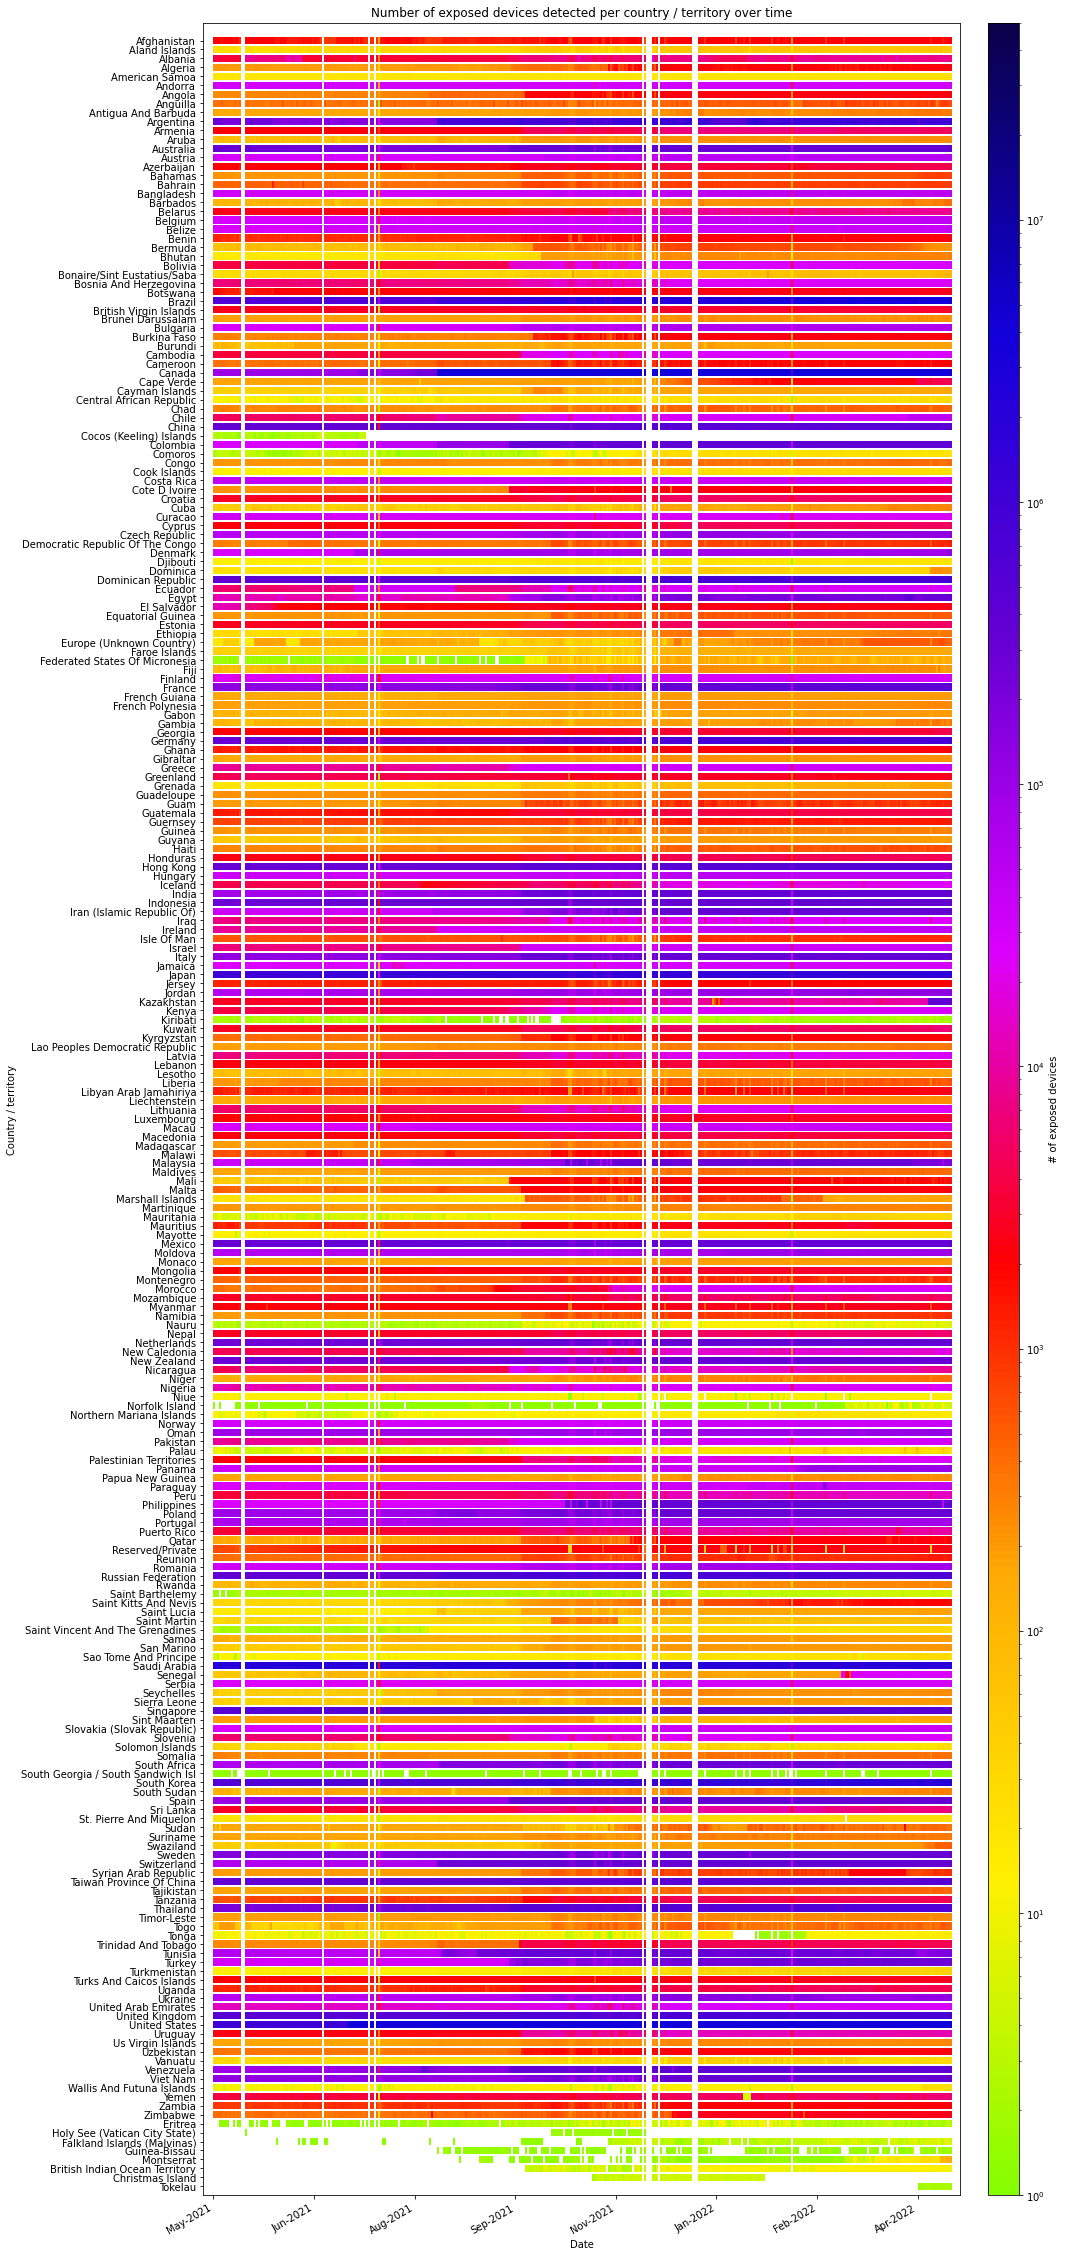

In [9]:

plt.rcParams["figure.figsize"] = (16.54, 44.38)

fig, ax = plt.subplots(figsize=(16.54, 44.38))
y = 0
done = 0

for country in country_names_sorted:
	for c in range(len(output[country])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[country][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(country_names))))}/{len(country_names)}: {country}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(country_names_sorted) + 1])
ax.set_yticks(np.arange(len(country_names_sorted)))
ax.set_yticklabels(country_names_sorted)

ax.set_xlabel('Date')
ax.set_ylabel('Country / territory')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=70 , pad=0.03)
cb.ax.set_ylabel('# of exposed devices')

ax.set_title("Number of exposed devices detected per country / territory over time")

plt.savefig('../images/exposed-bycountry-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()

In [79]:
stats_df = pd.DataFrame(columns=['country', 'max', 'avg', 'med'])

m = df.groupby(['country']).max().sort_values(by='count', ascending=False).head(10)
a = df.groupby(['country']).mean().sort_values(by='count', ascending=False).head(10)
f = df.groupby(['country']).median().sort_values(by='count', ascending=False).head(10)

for col, tab in zip(['max', 'avg', 'med'], [m, a, f]):
	for i, row in tab.iterrows():
		if i not in stats_df.country.values:
			stats_df = pd.concat([stats_df, pd.DataFrame({'country': [i], col: [row['count']]})])
		else:
			stats_df.loc[stats_df.country == i,col] = row['count']

stats_df.to_csv('stats.csv')
stats_df



,country,max,avg,med
0,United States,4720826,3603607.522599,4339814.5
0,Canada,2151450,1411156.172316,1959311.0
0,Brazil,1027708,671547.553672,719089.0
0,South Korea,816120,503199.805085,513567.0
0,Saudi Arabia,808542,753442.257062,763713.0
...,...,...,...,...
0,Kiribati,5,3.083086,3.0
0,Guinea-Bissau,4,1.522989,1.0
0,Tokelau,3,2.705882,3.0
0,Holy See (Vatican City State),2,1.790698,2.0


In [75]:
stats_df

,country,max,avg,med,population
0,United States,4720826,3603607.522599,4339814.5,331002651
0,Canada,2151450,1411156.172316,1959311.0,37742154
0,Brazil,1027708,671547.553672,719089.0,212559417
0,South Korea,816120,503199.805085,513567.0,51269185
0,Saudi Arabia,808542,753442.257062,763713.0,34813871
0,Argentina,792856,365045.237288,452220.5,45195774
0,Japan,696935,606352.853107,613046.5,126476461
0,Dominican Republic,472401,322344.305085,350703.0,10847910
0,Germany,462627,260205,242995,145934462
0,Russian Federation,458928,326410.666667,387197.5,83783942


In [80]:
stats_df = stats_df.head(10)
stats_df.loc[stats_df.country == 'Germany', 'avg'] = 260205
stats_df.loc[stats_df.country == 'Germany', 'med'] = 242995

stats_df['population'] = [331002651, 37742154, 212559417, 51269185, 34813871, 45195774, 126476461, 10847910, 145934462, 83783942]
stats_df['max_scaled'] = stats_df['max'] / (stats_df['population'] / 1000000)
stats_df['avg_scaled'] = stats_df['avg'] / (stats_df['population'] / 1000000)
stats_df['med_scaled'] = stats_df['med'] / (stats_df['population'] / 1000000)
stats_df

ValueError: Length of values (10) does not match length of index (240)